In [1]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [2]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"]
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"]
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"]

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

MIN_LEN = int(config["parametres"]["longor_min"])
MAX_LEN = config["parametres"]["longor_max"]
if MAX_LEN == "inf":
    MAX_LEN = np.inf

OPTIMIZACION_BAYESIANA = False

In [3]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)
longor_texte = texte_df["Texte"].apply(len)
texte_df = texte_df[(longor_texte > MIN_LEN) & (longor_texte < MAX_LEN)].reset_index(drop=True)

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    lista_dialectes_df=[
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    ],
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8295,Guion_II_d'Auvèrnhe,auvernhat,guion ii d'
8296,Institut_per_la_promocion_dels_estudis_socials,lengadocian,l'institut per la promocion dels estudis socia...
8297,Robert_Walpole,lengadocian,robert walpole 1èr comte d'oxford (1676-1745) ...
8298,Michal_Kováč,lengadocian,michal ková banquièr e òme politic (ubia 5 d'a...


In [4]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=0.2)

In [5]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [6]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.9325301204819277
Precision: 0.8039830923861653
Rappel: 0.8388342550458918
F1: 0.8184786906979721


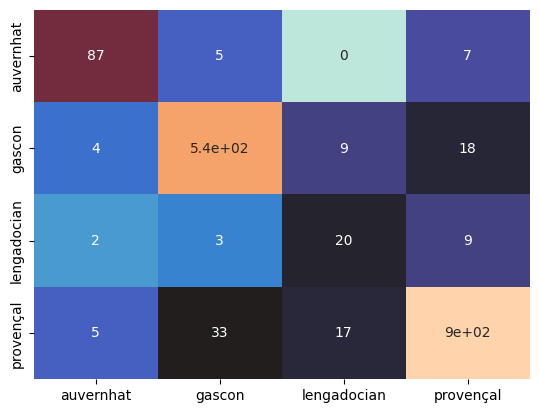

In [7]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(
        **melhor_params,
    )

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    for nom_param, valor_param in melhor_params.items():
        mlflow.log_param(nom_param, valor_param)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [8]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [9]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
79365,Masan_(Vauclusa),gascon,1.380548,2.065529e-01,0.273701,2.680479e-01,2.516986e-01,NaN
23111,Carlos_Salinas_de_Gortari,gascon,1.379659,2.475706e-01,0.289962,2.089932e-01,2.534746e-01,NaN
71948,Amati,lengadocian,1.377018,1.990522e-01,0.247598,2.927115e-01,2.606384e-01,NaN
10443,Pònt_delh_Diable_(Tuèis),lengadocian,1.374813,1.903089e-01,0.248706,2.865123e-01,2.744723e-01,NaN
33691,Gognies-Chaussée,lengadocian,1.373163,2.565459e-01,0.190125,3.028150e-01,2.505140e-01,NaN
...,...,...,...,...,...,...,...,...
39490,Pardias-Pietat,gascon,0.000035,1.257349e-06,0.999998,7.456907e-07,3.279076e-07,gascon
28199,Mandolina,gascon,0.000029,8.107720e-07,0.999998,6.073925e-07,4.480190e-07,gascon
60989,El_conde_Lucanor,gascon,0.000027,6.239354e-07,0.999998,3.440399e-07,8.043444e-07,NaN
15202,Sent_Estève_de_Baigòrri,gascon,0.000026,4.528124e-07,0.999998,1.038915e-06,2.356724e-07,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

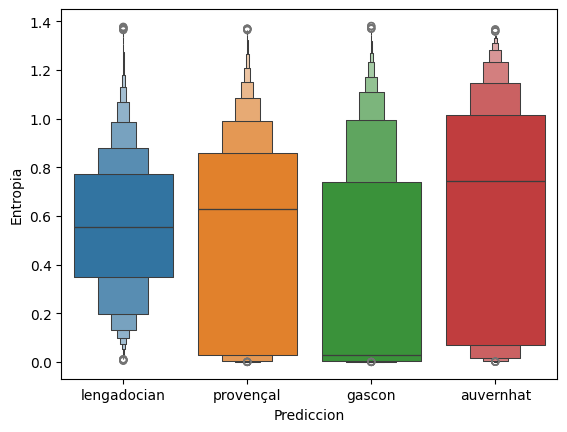

In [10]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [11]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
71948,Amati,lengadocian,1.377018,0.199052,0.247598,0.292711,0.260638,NaN
10443,Pònt_delh_Diable_(Tuèis),lengadocian,1.374813,0.190309,0.248706,0.286512,0.274472,NaN
33691,Gognies-Chaussée,lengadocian,1.373163,0.256546,0.190125,0.302815,0.250514,NaN
37128,Saez,lengadocian,1.370327,0.258381,0.181060,0.302584,0.257976,NaN
75773,Andry_Rajoelina,lengadocian,1.369099,0.226489,0.289223,0.297735,0.186554,NaN
55861,Abrocoma,lengadocian,1.365503,0.264936,0.168094,0.299219,0.267752,NaN
46367,Arne_Tiselius,lengadocian,1.363591,0.211609,0.208089,0.343150,0.237153,NaN
37831,Lengas_iranianas,lengadocian,1.362597,0.265613,0.263320,0.306980,0.164087,NaN
36862,La_Prénessaye,lengadocian,1.360840,0.195937,0.219419,0.347274,0.237370,NaN
11759,Ervy-le-Châtel,lengadocian,1.358624,0.271071,0.154024,0.292329,0.282575,NaN


In [12]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
78616,Nòuvic_Sent_Sepulcre,auvernhat,1.364891,0.326578,0.183745,0.259938,0.229738,NaN
26664,Sent_Merd_las_Aussinas,auvernhat,1.359461,0.308254,0.263657,0.158247,0.269842,NaN
68605,Three_Sisters_(Oregon),auvernhat,1.357670,0.339873,0.173013,0.230982,0.256131,NaN
46657,Mesnil-en-Arrouaise,auvernhat,1.357452,0.317338,0.201093,0.180963,0.300606,NaN
43523,ModèlːUICN_EN,auvernhat,1.339903,0.384338,0.226707,0.180826,0.208129,NaN
39994,Lei_de_Hubble,auvernhat,1.339884,0.351109,0.288936,0.154457,0.205499,NaN
16678,Lengas_kuliak,auvernhat,1.334757,0.305596,0.122016,0.276868,0.295520,NaN
75665,Karin_Viard,auvernhat,1.333242,0.361437,0.148044,0.285930,0.204589,NaN
42650,Saint-Romain-les-Atheux,auvernhat,1.332604,0.341839,0.154795,0.317776,0.185591,NaN
52817,Trivium,auvernhat,1.330595,0.340357,0.248412,0.286442,0.124788,NaN


In [13]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       513
gascon         2847
lengadocian     161
provençal      4779
Name: Article, dtype: int64

In [14]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1270
gascon          9773
lengadocian    49991
provençal      20574
Name: Article, dtype: int64

In [15]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [16]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values("FI", ascending=False).head(60)

,FI,TokenIndex,Token
17212,0.091591,17212,ġua
9632,0.060475,9632,ġdei
2203,0.040795,2203,es
9906,0.033790,9906,ġdeu
9537,0.023374,9537,ġdau
12624,0.018442,12624,ġlei
17161,0.017764,17161,ġtrã²ba
1857,0.013283,1857,ei
12752,0.012857,12752,ġlingã¼istica
5192,0.012619,5192,tamar
